In [1]:
!pip install -q webull yfinance pandas_ta pandas_market_calendars

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.6/203.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.1 MB/s eta 0:00:00


In [2]:
from math import ceil
from pandas_ta import macd, rsi
from yfinance import Ticker, download
from webull import paper_webull as pwb
from datetime import datetime, date, time
from pandas_market_calendars import get_calendar
from yfinance.exceptions import YFRateLimitError
from pandas import concat, Series, DataFrame, MultiIndex, to_datetime, Timedelta

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
def getDictionary(ticker,get_dataframe=True):
    from math import ceil
    from yfinance import Ticker, download
    from webull import paper_webull as pwb
    from datetime import datetime, date, time
    !pip install -q webull pandas_market_calendars
    from pandas_market_calendars import get_calendar
    from yfinance.exceptions import YFRateLimitError
    from pandas import concat, to_datetime, Timedelta
    try: return Ticker(ticker).history(period='max') 
    except YFRateLimitError:
        df = download(ticker, multi_level_index = False, auto_adjust=True, period='max', progress=False)
        if len(df): return df
        #if 'inceptionDate' in pwb().get_ticker_info(ticker):
        start_date = to_datetime(pwb().get_ticker_info(ticker)['inceptionDate']).date() if 'inceptionDate' in pwb().get_ticker_info(ticker) else to_datetime('01-01-2000').date()
        today_date = date.today()
        dates = [(start_date+Timedelta(days=365*(i))) for i in range(int(ceil((today_date - start_date)/Timedelta(days=365))))]
        days = (today_date - dates[-1]).days
        if days < 365 and days > 0: dates[-1] = today_date
        dictionary = {'Start Date: ' + dates[i].strftime('%Y-%m-%d') : pwb().get_bars(stock=ticker,
        count=len(get_calendar('NYSE').schedule(dates[i],dates[i+1])), interval='d1',
        timeStamp=int(datetime.combine(dates[i+1]+Timedelta(days=1),
time(0,0)).timestamp())) for i in range(len(dates)) if i!=(len(dates)-1)}
        if get_dataframe: dictionary = concat(list(dictionary.values())).reset_index().drop_duplicates().set_index('timestamp')
        return dictionary
    print('No data found.')
    return DataFrame()

In [5]:
def add_indicators(df):
    df.rename(columns={i:i.capitalize() for i in df.columns},inplace=True)
    df = df.join(macd(df['Close']))
    df = df.join(rsi(df['Close']))
    df['Return'] = df['Close'].pct_change()
    #df['TargetReturn'] = df['Return'].shift(-1)
    df['TargetReturn'] = (df['Return'].shift(-1) > 0).astype(int)
    df.dropna(inplace=True)
    return df
def add_indicators(df):
    df.rename(columns={i: i.capitalize() for i in df.columns}, inplace=True)
    df = df.join(macd(df['Close']))
    df = df.join(rsi(df['Close']))
    df['Return'] = df['Close'].pct_change()
    df['Target'] = (df['Return'].shift(-1) > 0).astype(int)
    df.dropna(inplace=True)
    return df

In [6]:
# 3. Data Preprocessing
def preprocess(df, backcandles=60):
    feature_columns = df.columns.difference(['TargetReturn']).tolist()
    features = df[feature_columns].values
    target = df['TargetReturn'].values.reshape(-1, 1)
    
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)

    X, y = [], []
    for i in range(backcandles, len(scaled_features)):
        X.append(scaled_features[i-backcandles:i])
        y.append(scaled_target[i])
    
    return np.array(X), np.array(y), feature_scaler, target_scaler
# 4. Build Model
def build_model(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(100, return_sequences=True)(lstm_input)
    x = LSTM(50)(x)
    x = Dense(1)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model(input_shape):
    inp = Input(shape=input_shape, name="input")
    x = LSTM(64, return_sequences=False)(inp)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # binary output
    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
from sklearn.preprocessing import StandardScaler

def create_sequences(X, y, lookback=10):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [7]:
import numpy as np
import pandas as pd
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

2025-07-26 15:03:32.257959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753542212.285783    9827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753542212.294332    9827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df.columns

In [ ]:
df = getDictionary('SPY')
df = add_indicators(df)
# Define features and target
#features = ['Close', 'MACD_12_26_9',
#'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14']  # adjust based on actual columns
features = ['Close', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'RSI_14', 'Momentum', 'SMA_10', 'EMA_10', 'OBV']
X = df[features].values
y = df['Target'].values
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
lookback = 20
X_seq, y_seq = create_sequences(X_scaled, y, lookback)
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X_seq):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]
    break  # just the first fold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inp)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((lookback, X_seq.shape[2]))
'''
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=False,
)
'''
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=[early_stop]
)

# Predict probabilities
y_pred_probs = model.predict(X_val)
# Classify: up = 1, down = 0
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report
print("Directional Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=4))

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming getDictionary() and add_indicators() are defined elsewhere
df = getDictionary('SPY')
df = add_indicators(df)

# Additional features (example: lagged returns)
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['return_1'] = df['Return'].shift(1)
df['return_3'] = df['Return'].rolling(3).mean()
df = df.dropna()

features = ['Close', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'RSI_14', 'log_return', 'return_1', 'return_3']
X = df[features].values
y = df['Target'].values

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", class_weight_dict)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence creation function
def create_sequences(X, y, lookback=20):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

lookback = 20
X_seq, y_seq = create_sequences(X_scaled, y, lookback)

# Model building function with stacked LSTM layers
def build_model(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inp)
    x = LSTM(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Callbacks for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
accuracies = []
'''
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq), 1):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

    model = build_model((lookback, X_seq.shape[2]))
    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        shuffle=False,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    y_pred_probs = model.predict(X_val)
    y_pred = (y_pred_probs > 0.5).astype(int)

    acc = accuracy_score(y_val, y_pred)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, digits=4))
    accuracies.append(acc)
'''
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq), 1):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

    model = build_model((lookback, X_seq.shape[2]))
    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        shuffle=False,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save the model for this fold
    model_path = f'lstm_model_fold{fold}.h5'
    model.save(model_path)
    print(f"Saved model for fold {fold} to {model_path}")
    
    y_pred_probs = model.predict(X_val)
    y_pred = (y_pred_probs > 0.5).astype(int)

    acc = accuracy_score(y_val, y_pred)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, digits=4))
    accuracies.append(acc)
print(f"Average Accuracy over folds: {np.mean(accuracies):.4f}")

Class distribution: {0: 3767, 1: 4376}
Class weights: {0: 1.0808335545526944, 1: 0.9304159049360147}
Epoch 1/100


2025-07-26 15:04:25.216018: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4819 - loss: 0.6966 - val_accuracy: 0.5159 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4723 - loss: 0.6970 - val_accuracy: 0.5107 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5185 - loss: 0.6952 - val_accuracy: 0.5144 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4920 - loss: 0.6977 - val_accuracy: 0.5159 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5067 - loss: 0.6960 - val_accuracy: 0.5107 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5005 - loss: 0.6952 - val_accuracy: 0.5196 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5153 - loss: 0.6941 - val_accuracy

In [ ]:
X, y, feature_scaler, target_scaler = preprocess(df)

# Split train/test
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build model
#model = build_model(input_shape=(X.shape[1], X.shape[2]))
model = build_model((X_train.shape[1], X_train.shape[2]))
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        shuffle=False
    )
    break  # Just run on the first fold for now
'''
# Train
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks
)
'''
# Evaluate
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
direction_accuracy = np.mean((y_pred_inverse > 0) == (y_test_inverse > 0))

print(f"MAE: {mae:.6f}")
print(f"Directional Accuracy: {direction_accuracy:.2%}")

In [ ]:
start_date = to_datetime(pwb().get_ticker_info('QQQ')['inceptionDate'])

In [ ]:
today_date = date.today()
dates = [(start_date+Timedelta(days=365*(i))) for i in range(int(ceil((today_date - start_date.date())/Timedelta(days=365))))]
days = (today_date - dates[-1].date()).days
if days < 365 and days > 0: dates[-1] = today_date

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import History
from keras.layers import LSTM, Input, Dense, Dropout, Activation, TimeDistributed
def getModelPredictions(ticker):
    df = getDictionary(ticker)
    if len(df):
        df.rename(columns={i:i.capitalize() for i in df.columns},inplace=True)
        df = df.join(macd(df.Close))
        df = df.join(rsi(df.Close))
        df['pctChange'] = df.Close.pct_change()
        df['PostiveReturns'] = (df['pctChange'] > 0).astype(int)
        df['TargetNextClose'] = df.Close.shift(-1)
        df.rename(columns = {i:i.split('_',1)[0] for i in df.columns},inplace=True)
        df.dropna(inplace=True)
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler(feature_range=(0,1))
        scaled_df = sc.fit_transform(df)
        
        def data_preprocessing(backcandles=60):
            X_data = []
            for i in range(len(df.columns[:-2])):
                X_data.append([])
                for j in range(backcandles, scaled_df.shape[0]): X_data[i].append(scaled_df[j-backcandles:j, i])
            X_data = np.moveaxis(X_data, [0], [2])
            print(X_data.shape)
            X_data, y_data = np.array(X_data), scaled_df[backcandles:,-1]
            print(X_data.shape, y_data.shape)
            y_data = np.reshape(y_data,(len(y_data),1))
            print(y_data.shape)
            return X_data, y_data
        X, y = data_preprocessing()
        splitLimits = [int(len(X)*0.8), int(len(X)*0.7), int(len(X)*0.6)]
        X_train, X_test = X[:splitLimits[0]], X[splitLimits[0]:]
        y_train, y_test = y[:splitLimits[0]], y[splitLimits[0]:]
        lstm_input = Input(shape=(60, len(df.columns[:-2])), name="lstm_input")
        inputs = LSTM(150, name="first_layer")(lstm_input)
        inputs = Dense(1, name = 'dense_layer')(inputs)
        output = Activation('linear', name = "output")(inputs)
        model = Model(inputs=lstm_input, outputs=output)
        adam = optimizers.Adam()
        model.compile(optimizer='adam',loss='mse')
        model.fit(x=X_train,y=y_train,batch_size=15,epochs=10,shuffle=True,validation_split=0.2)
        return model.predict(X_test).flatten()
    return DataFrame()

In [5]:
df = getDictionary('SPY')

In [6]:
df.rename(columns={i:i.capitalize() for i in df.columns},inplace=True)

In [7]:
df = df.join(macd(df.Close))
df = df.join(rsi(df.Close))

In [8]:
df['pctChange'] = df.Close.pct_change()

In [ ]:
df['PostiveReturns'] = (df['pctChange'] > 0).astype(int)

In [9]:
df['TargetReturn'] = df['Close'].shift(-1)

In [10]:
df.rename(columns = {i:i.split('_',1)[0] for i in df.columns},inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df.iloc[:5,:-1] 

,Open,High,Low,Close,Volume,Vwap,MACD,MACDh,MACDs,RSI,pctChange
timestamp,,,,,,,,,,,
1993-03-18 00:00:00-05:00,34.72,34.94,34.72,34.79,59300.0,0.0,0.233896,-0.027906,0.261803,57.789369,0.006073
1993-03-19 00:00:00-05:00,34.77,34.77,34.58,34.58,66900.0,0.0,0.209370,-0.041946,0.251316,52.963996,-0.006036
1993-03-22 00:00:00-05:00,34.24,34.46,34.22,34.39,183400.0,0.0,0.172611,-0.062964,0.235575,48.979136,-0.005495
1993-03-23 00:00:00-05:00,34.48,34.51,34.41,34.46,55200.0,0.0,0.147429,-0.070517,0.217946,50.458022,0.002035
1993-03-24 00:00:00-05:00,34.41,34.60,34.24,34.46,37200.0,0.0,0.126019,-0.073542,0.199560,50.458022,0.000000


In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scaled_df = sc.fit_transform(df)

In [15]:
scaled_df.shape

(8144, 12)

In [16]:
import numpy as np
def data_preprocessing(df,scaled_df,backcandles=60):
    X_data = []
    for i in range(len(df.columns[:-2])):
        X_data.append([])
        for j in range(backcandles, scaled_df.shape[0]): X_data[i].append(scaled_df[j-backcandles:j, i])
    X_data = np.moveaxis(X_data, [0], [2])
    print(X_data.shape)
    X_data, y_data = np.array(X_data), scaled_df[backcandles:,-1]
    print(X_data.shape, y_data.shape)
    y_data = np.reshape(y_data,(len(y_data),1))
    print(y_data.shape)
    return X_data, y_data

In [18]:
X, y = data_preprocessing(df,scaled_df)
splitLimits = [int(len(X)*0.8), int(len(X)*0.7), int(len(X)*0.6)]
X_train, X_test = X[:splitLimits[0]], X[splitLimits[0]:]
y_train, y_test = y[:splitLimits[0]], y[splitLimits[0]:]

(8084, 60, 10)
(8084, 60, 10) (8084,)
(8084, 1)


In [ ]:
X_train.shape, y_train.shape

In [19]:
import tensorflow as tf
from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import History
from keras.layers import LSTM, Input, Dense, Dropout, Activation, TimeDistributed

lstm_input = Input(shape=(60, len(df.columns[:-2])), name="lstm_input")
inputs = LSTM(150, name="first_layer")(lstm_input)
inputs = Dense(1, name = 'dense_layer')(inputs)
output = Activation('linear', name = "output")(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer='adam',loss='mse')
model.fit(x=X_train,y=y_train,batch_size=15,epochs=20,shuffle=True,validation_split=0.2)

2025-07-26 23:03:50.534463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753571030.813001      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753571030.889817      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-26 23:04:06.271734: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0016 - val_loss: 2.7352e-05
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 9.7940e-06 - val_loss: 2.6538e-05
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 9.1519e-06 - val_loss: 3.5757e-05
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 1.2072e-05 - val_loss: 2.2543e-05
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 1.0158e-05 - val_loss: 2.0702e-05
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 1.1722e-05 - val_loss: 5.1490e-05
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 1.0777e-05 - val_loss: 5.0183e-05
Epoch 8/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - loss: 1.7309e-05 - val_loss: 1.9640e-05
Epoch 9/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 1.2768e-05 - val_loss: 1.8610e-05
Epoch 10/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - loss: 1.5099e-05 - val_loss: 1.8031e-05
Epoch 11/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 17

In [20]:
y_pred = model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


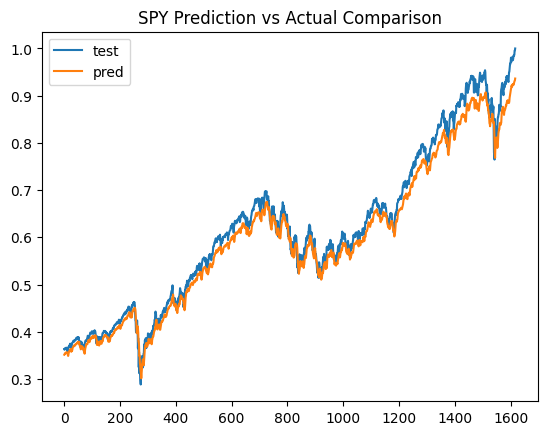

In [21]:
concat([DataFrame(y_test,columns=['test']), 
DataFrame(y_pred,columns=['pred'])],axis=1).plot(title='SPY Prediction vs Actual Comparison');

In [22]:
!pip install -q backtesting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 3.1 MB/s eta 0:00:00a 0:00:01


In [23]:
from backtesting.lib import *
from backtesting import Backtest, Strategy

Loading BokehJS ...

In [24]:
df.index = to_datetime(df.index)

In [25]:
df2 = df.reset_index()[df.reset_index()['timestamp'].apply(lambda x: x.year == datetime.today().year and x.month <6 ) == False].set_index('timestamp').copy()
df3 = df.reset_index()[df.reset_index()['timestamp'].apply(lambda x: x.year == datetime.today().year and x.month >= 6)].set_index('timestamp').copy()

In [28]:
# This is how many rows were used for training
num_train = splitLimits[0]  # 80% of data
num_total = len(df)

# Number of test samples
num_test = num_total - num_train

# Get corresponding test portion of df
df_trimmed = df.iloc[60:]  # because first 60 rows were dropped due to lookback window
df_test = df_trimmed.iloc[-len(y_pred):].copy()
df_test['LSTM_Pred'] = predicted_inversed

# Inverse scale predictions (only the predicted target column)
predicted_scaled = np.zeros((len(y_pred), scaled_df.shape[1]))
predicted_scaled[:, -1] = y_pred.flatten()
predicted_inversed = sc.inverse_transform(predicted_scaled)[:, -1]

# Attach predictions
df_test['LSTM_Pred'] = predicted_inversed

In [33]:
class LSTMTradingStrategy(Strategy):
    def init(self):
        # Nothing to initialize, as predictions are already in the dataframe
        pass

    def next(self):
        # Access the last predicted price and actual close price
        predicted_price = self.data.LSTM_Pred[-1]
        current_price = self.data.Close[-1]
        
        # Define a prediction buffer (e.g. 0.5% difference required to trigger a trade)
        threshold = 0.005  # 0.5%

        # Buy if no position and prediction is significantly higher than current price
        if not self.position:
            if predicted_price > current_price * (1 + threshold):
                self.buy()
        
        # Exit if holding a position and prediction drops significantly below price
        elif self.position:
            if predicted_price < current_price * (1 - threshold):
                self.position.close()

from pytz import timezone

# Match timezone of df_test.index (America/New_York)
tz_aware_cutoff = to_datetime('2025-06-01').tz_localize('America/New_York')

# Filter the DataFrame
df_test = df_test[df_test.index >= tz_aware_cutoff]

# Backtest
bt = Backtest(df_test, LSTMTradingStrategy, cash=10000, commission=.002)
results = bt.run()
print(results)
bt.plot()

Backtest.run:   0%|          | 0/36 [00:00<?, ?bar/s]

Start                     2025-06-02 00:00...
End                       2025-07-24 00:00...
Duration                     52 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.35414
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

GridPlot(id='p1333', ...)

In [34]:
print(results.to_dict())

{'Start': Timestamp('2025-06-02 00:00:00-0400', tz='America/New_York'), 'End': Timestamp('2025-07-24 00:00:00-0400', tz='America/New_York'), 'Duration': Timedelta('52 days 00:00:00'), 'Exposure Time [%]': 0.0, 'Equity Final [$]': 10000.0, 'Equity Peak [$]': 10000.0, 'Return [%]': 0.0, 'Buy & Hold Return [%]': 7.354135643698376, 'Return (Ann.) [%]': 0.0, 'Volatility (Ann.) [%]': 0.0, 'CAGR [%]': 0.0, 'Sharpe Ratio': nan, 'Sortino Ratio': nan, 'Calmar Ratio': nan, 'Alpha [%]': 0.0, 'Beta': 0.0, 'Max. Drawdown [%]': -0.0, 'Avg. Drawdown [%]': nan, 'Max. Drawdown Duration': nan, 'Avg. Drawdown Duration': nan, '# Trades': 0, 'Win Rate [%]': nan, 'Best Trade [%]': nan, 'Worst Trade [%]': nan, 'Avg. Trade [%]': nan, 'Max. Trade Duration': nan, 'Avg. Trade Duration': nan, 'Profit Factor': nan, 'Expectancy [%]': nan, 'SQN': nan, 'Kelly Criterion': nan, '_strategy': <Strategy LSTMTradingStrategy>, '_equity_curve':                             Equity  DrawdownPct  DrawdownDuration
2025-06-02 00:00

In [45]:
import numpy as np
import pandas as pd

class LSTMTradingStrategy(Strategy):
    def init(self):
        # No initialization logic yet
        pass

    def next(self):
        # Fetch predicted and actual close prices
        predicted = self.data.LSTM_Pred[-1]
        close = self.data.Close[-1]

        # Basic sanity check
        if np.isnan(predicted) or np.isnan(close):
            print(f"Skipping due to NaN: Date: {self.data.index[-1]}, Pred: {predicted}, Close: {close}")
            return

        # Print debug info
        print(f"[{self.data.index[-1]}] Predicted: {predicted:.2f}, Close: {close:.2f}, Position: {self.position.size}")

        # Simple strategy logic
        if not self.position and predicted > close:
            print("→ BUY triggered")
            self.buy()
        elif self.position and predicted < close:
            print("→ SELL triggered")
            self.position.close()

# Align predicted values (you likely have this already)
df_test['LSTM_Pred'] = df_test['LSTM_Pred'].shift(1)

# Drop any rows with NaNs after the shift
df_test = df_test.dropna(subset=['LSTM_Pred'])

In [47]:
predicted_scaled = model.predict(X_test)
predicted = sc.inverse_transform(predicted_scaled)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


ValueError: non-broadcastable output operand with shape (1617,1) doesn't match the broadcast shape (1617,12)

In [49]:
close_prices = df['Close'].values.reshape(-1, 1)

# Create the scaler
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training target data
target_scaler.fit(close_prices)

# Later, to scale targets for training:
scaled_close = target_scaler.transform(close_prices)

In [66]:
predicted.shape

(1617, 1)

In [70]:
df_test.iloc[-len(predicted):]

,Open,High,Low,Close,Volume,Vwap,MACD,MACDh,MACDs,RSI,pctChange,TargetReturn,LSTM_Pred
2025-06-04 00:00:00-04:00,595.20,596.19,593.73,594.17,57314199.0,595.15,9.183309,-0.183031,9.366340,64.350336,-0.000269,591.30,559.187934
2025-06-05 00:00:00-04:00,595.87,597.23,589.31,591.30,92436397.0,593.49,8.823595,-0.434196,9.257791,61.306923,-0.004830,597.37,560.431086
2025-06-06 00:00:00-04:00,596.90,599.06,595.10,597.37,66588743.0,597.39,8.925431,-0.265889,9.191319,65.069663,0.010266,597.91,562.755914
2025-06-09 00:00:00-04:00,597.95,599.48,596.73,597.91,53016418.0,598.29,8.946579,-0.195792,9.142371,65.392094,0.000904,601.30,564.374452
2025-06-10 00:00:00-04:00,598.45,601.69,597.32,601.30,66246973.0,599.86,9.131620,-0.008601,9.140221,67.424960,0.005670,599.59,563.794585
2025-06-11 00:00:00-04:00,602.41,603.28,597.50,599.59,73658225.0,600.57,9.036121,-0.083280,9.119401,65.340019,-0.002844,601.97,566.538740
2025-06-12 00:00:00-04:00,598.24,601.97,597.75,601.97,64129003.0,600.77,9.048181,-0.056976,9.105157,66.875309,0.003969,595.24,568.025491
2025-06-13 00:00:00-04:00,596.74,600.08,593.72,595.24,89505996.0,596.44,8.417651,-0.550005,8.967656,58.926604,-0.011180,600.90,569.783805
2025-06-16 00:00:00-04:00,598.63,602.67,598.45,600.90,79984125.0,600.96,8.279229,-0.550742,8.829970,62.918456,0.009509,595.77,570.116617
2025-06-17 00:00:00-04:00,598.44,599.98,595.00,595.77,82209365.0,597.43,7.667197,-0.930219,8.597416,57.466937,-0.008537,595.68,570.928747


In [65]:
predicted_scaled = model.predict(X_test)  # shape (samples, 1)

# Step 3: Inverse transform predictions using target scaler
predicted = target_scaler.inverse_transform(predicted_scaled)  # shape (samples, 1)

# Step 4: Align predicted values with df_test (make sure length matches)
# Here, df_test might be longer than predictions, so align by slicing from the end:
df_test_aligned = df_test.iloc[-len(predicted):].copy()

window_size = 60
num_predictions = predicted.shape[0]

# The indices in df_test that correspond to predictions are from (window_size - 1) onward:
prediction_indices = df_test.index[window_size - 1 : window_size - 1 + num_predictions]

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


ValueError: Length of values (1617) does not match length of index (35)

In [60]:
df_test_aligned_clean = df_test_aligned.dropna(subset=['Open', 'High', 'Low', 'Close'])

In [75]:
class LSTMTradingStrategy(Strategy):
    def init(self):
        self.max_predicted = -np.inf
        self.lookback = 60
        self.num_features = self.df3.shape[1]

    def predict_price(self, idx):
        if idx - self.lookback + 1 < 0 or idx >= len(self.df3):
            return np.nan

        window = self.df3.iloc[idx - self.lookback + 1 : idx + 1].values
        window_scaled = self.input_scaler.transform(window)
        window_scaled = window_scaled.reshape(1, self.lookback, self.num_features)
        pred_scaled = self.model.predict(window_scaled)
        pred_price = self.target_scaler.inverse_transform(pred_scaled)[0][0]
        return pred_price

    def next(self):
        i = len(self.data) - 1

        current_pred = self.predict_price(i)
        future_pred = self.predict_price(i + 1)
        close = self.data.Close[-1]

        if np.isnan(current_pred) or np.isnan(future_pred) or np.isnan(close):
            return

        if current_pred > self.max_predicted:
            self.max_predicted = current_pred

        print(f"[{self.data.index[-1]}] Current Pred: {current_pred:.2f}, Future Pred: {future_pred:.2f}, Close: {close:.2f}, Position: {self.position.size}")

        if future_pred > current_pred:
            self.buy()
        elif self.position and current_pred >= self.max_predicted and future_pred < current_pred:
            self.position.close()
            self.max_predicted = -np.inf
LSTMTradingStrategy.df3 = df3
LSTMTradingStrategy.model = model
LSTMTradingStrategy.input_scaler = sc
LSTMTradingStrategy.target_scaler = target_scaler
from backtesting import Backtest

# Use the OHLC data from df3 for backtesting (make sure it has these columns)
bt = Backtest(df3, LSTMTradingStrategy, cash=10000, commission=0.002)

# Run backtest
results = bt.run()
print(results)

# Plot results
bt.plot()

Backtest.run:   0%|          | 0/36 [00:00<?, ?bar/s]

Start                     2025-06-02 00:00...
End                       2025-07-24 00:00...
Duration                     52 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.35414
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

GridPlot(id='p1861', ...)

In [71]:
class LSTMTradingStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        predicted = self.data.LSTM_Pred[-1]
        close = self.data.Close[-1]

        if np.isnan(predicted) or np.isnan(close):
            print(f"Skipping due to NaN: Date: {self.data.index[-1]}, Pred: {predicted}, Close: {close}")
            return

        print(f"[{self.data.index[-1]}] Predicted: {predicted:.2f}, Close: {close:.2f}, Position: {self.position.size}")

        if not self.position and predicted > close:
            print("→ BUY triggered")
            self.buy()
        elif self.position and predicted < close:
            print("→ SELL triggered")
            self.position.close()

bt = Backtest(df_test.iloc[-len(predicted):], LSTMTradingStrategy, cash=10000, commission=0.002)
results = bt.run()
print(results)
bt.plot()

Backtest.run:   0%|          | 0/34 [00:00<?, ?bar/s]

[2025-06-05 00:00:00-04:00] Predicted: 560.43, Close: 591.30, Position: 0
[2025-06-06 00:00:00-04:00] Predicted: 562.76, Close: 597.37, Position: 0
[2025-06-09 00:00:00-04:00] Predicted: 564.37, Close: 597.91, Position: 0
[2025-06-10 00:00:00-04:00] Predicted: 563.79, Close: 601.30, Position: 0
[2025-06-11 00:00:00-04:00] Predicted: 566.54, Close: 599.59, Position: 0
[2025-06-12 00:00:00-04:00] Predicted: 568.03, Close: 601.97, Position: 0
[2025-06-13 00:00:00-04:00] Predicted: 569.78, Close: 595.24, Position: 0
[2025-06-16 00:00:00-04:00] Predicted: 570.12, Close: 600.90, Position: 0
[2025-06-17 00:00:00-04:00] Predicted: 570.93, Close: 595.77, Position: 0
[2025-06-18 00:00:00-04:00] Predicted: 567.83, Close: 595.68, Position: 0
[2025-06-20 00:00:00-04:00] Predicted: 569.69, Close: 594.28, Position: 0
[2025-06-23 00:00:00-04:00] Predicted: 568.14, Close: 600.15, Position: 0
[2025-06-24 00:00:00-04:00] Predicted: 567.90, Close: 606.78, Position: 0
[2025-06-25 00:00:00-04:00] Predicted:

GridPlot(id='p1685', ...)

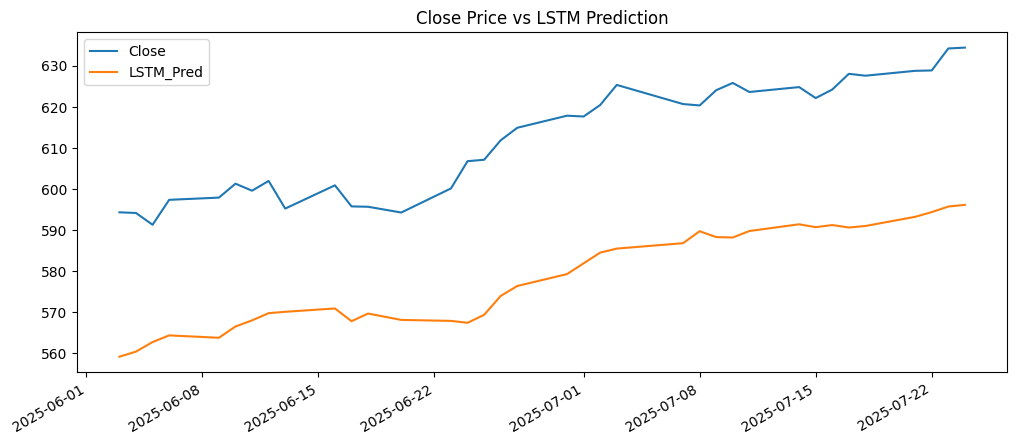

In [38]:
import matplotlib.pyplot as plt

df_test[['Close', 'LSTM_Pred']].plot(figsize=(12, 5), title='Close Price vs LSTM Prediction')
plt.show()

In [ ]:
target = df2['TargetNextClose'].values.reshape(-1, 1)
features = df2.drop(columns=['TargetNextClose']).values

sc = MinMaxScaler()
scaled_features = sc.fit_transform(features)

X, y = data_preprocessing(df2, scaled_features)

In [ ]:
X, y = data_preprocessing(df2)
splitLimits = [int(len(X)*0.8), int(len(X)*0.7), int(len(X)*0.6)]
X_train, X_test = X[:splitLimits[0]], X[splitLimits[0]:]
y_train, y_test = y[:splitLimits[0]], y[splitLimits[0]:]

In [ ]:
import tensorflow as tf
from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import History
from keras.layers import LSTM, Input, Dense, Dropout, Activation, TimeDistributed

lstm_input = Input(shape=(60, len(df2.columns[:-2])), name="lstm_input")
inputs = LSTM(150, name="first_layer")(lstm_input)
inputs = Dense(1, name = 'dense_layer')(inputs)
output = Activation('linear', name = "output")(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer='adam',loss='mse')
model.fit(x=X_train,y=y_train,batch_size=15,epochs=20,shuffle=True,validation_split=0.2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Example: Train LSTM on df2
prices = df2['Close'].values
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
lookback = 20
X, y = [], []
for i in range(len(prices_scaled) - lookback):
    X.append(prices_scaled[i:i+lookback])
    y.append(prices_scaled[i+lookback])
X, y = np.array(X), np.array(y)

# Build and train LSTM
model = Sequential([
    LSTM(50, input_shape=(lookback, 1)),
    Dense(1)
])
from keras.losses import MeanSquaredError
model.compile(optimizer='adam', loss=MeanSquaredError())
model.fit(X, y, epochs=10, batch_size=32)

# Save for use in backtesting
model.save('lstm_model.h5')

In [21]:
from backtesting import Strategy
from keras.models import load_model
import numpy as np

class LSTMTradingStrategy(Strategy):
    # Declare class parameters to enable passing them via bt.run()
    model_path = 'lstm_model.h5'
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Vwap', 'MACD_12_26_9', 'MACDh_12_26_9']
    lookback = 20
    threshold = 0.01  # 1% threshold for trade action

    def init(self):
        # Load trained model
        self.model = load_model(self.model_path)

        # Extract and validate features
        features_df = self.data.df[self.feature_cols]
        features = features_df.to_numpy()

        if len(features) <= self.lookback:
            print("Not enough data for prediction.")
            self.predictions = np.array([])
            return

        # Create LSTM sequences
        self.X = self.create_sequences(features, self.lookback)

        # Predict
        self.predictions = self.model.predict(self.X, verbose=0).flatten()

    def create_sequences(self, data_array, lookback):
        return np.array([
            data_array[i - lookback:i] for i in range(lookback, len(data_array))
        ])

    def next(self):
        i = len(self.data.Close) - self.lookback - 1

        # Check if predictions array is empty or if index is invalid
        if len(self.predictions) == 0 or i < 0 or i >= len(self.predictions):
            return

        predicted_price = self.predictions[i]
        current_price = self.data.Close[-1]

        # Print predicted and actual prices for debugging
        print(f"Predicted: {predicted_price}, Current: {current_price}")

        # If the predicted price is greater than the current price by threshold, buy
        if predicted_price > current_price * (1 + self.threshold) and not self.position:
            print(f"Buying at {current_price}, Predicted: {predicted_price}")
            self.buy()

        # If the predicted price is lower than the current price by threshold, sell
        elif predicted_price < current_price * (1 - self.threshold) and self.position:
            print(f"Selling at {current_price}, Predicted: {predicted_price}")
            self.position.close()

In [ ]:
from backtesting import Strategy
from keras.models import load_model
import numpy as np

class LSTMTradingStrategy(Strategy):
    # Declare class parameters to enable passing them via bt.run()
    model_path = 'lstm_model.h5'
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Vwap', 'MACD_12_26_9', 'MACDh_12_26_9']
    lookback = 20

    def init(self):
        # Load trained model
        self.model = load_model(self.model_path)

        # Extract and validate features
        features_df = self.data.df[self.feature_cols]
        features = features_df.to_numpy()

        if len(features) <= self.lookback:
            print("Not enough data for prediction.")
            self.predictions = np.array([])
            return

        # Create LSTM sequences
        self.X = self.create_sequences(features, self.lookback)

        # Predict
        self.predictions = self.model.predict(self.X, verbose=0).flatten()

    def create_sequences(self, data_array, lookback):
        return np.array([
            data_array[i - lookback:i] for i in range(lookback, len(data_array))
        ])

    def next(self):
        i = len(self.data.Close) - self.lookback - 1

        if len(self.predictions) == 0 or i < 0 or i >= len(self.predictions):
            return

        predicted_price = self.predictions[i]
        current_price = self.data.Close[-1]

        if predicted_price > current_price and not self.position:
            self.buy()
        elif predicted_price < current_price and self.position:
            self.position.close()

In [ ]:
df3.columns

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assuming you have the features `X` and target `y`
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences (as done earlier)
lookback = 20
X_seq, y_seq = create_sequences(X_scaled, y, lookback)

# Build the LSTM model (change last layer for regression)
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Linear activation for price prediction
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

from sklearn.preprocessing import StandardScaler

# Assuming your target variable is 'Close'
scaler_target = StandardScaler()
# Scale the target variable 'y' (e.g., Close prices) separately
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1))

# Now train the model on scaled features (X) and scaled target (y_scaled)
model.fit(X_seq, y_scaled, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

# Save the model and target scaler for later use
model.save('lstm_model_regression.h5')
import joblib
joblib.dump(scaler_target, 'scaler_target.pkl')  # Save the target scaler

#model = build_model((lookback, X_seq.shape[2]))
#model.fit(X_seq, y_seq, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Save the model
#model.save('lstm_model_regression.h5')

Epoch 1/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.0733 - mae: 0.9697 - val_loss: 0.9883 - val_mae: 0.9689
Epoch 2/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9155 - mae: 0.8985 - val_loss: 0.9755 - val_mae: 0.9655
Epoch 3/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.8674 - mae: 0.8602 - val_loss: 0.9624 - val_mae: 0.9318
Epoch 4/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.7786 - mae: 0.7802 - val_loss: 0.9586 - val_mae: 0.9160
Epoch 5/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.7099 - mae: 0.7199 - val_loss: 0.9292 - val_mae: 0.8886
Epoch 6/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.6494 - mae: 0.6566 - val_loss: 0.8996 - val_mae: 0.8677
Epoch 7/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.5788 - mae: 0.5973 - val_loss: 0.8837 - val_mae: 0.8331
Epoch 8/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5002 - mae: 0.5206 - val_loss: 0.8963 - val_mae: 0.8328
Epoch 9/15
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/

['scaler_target.pkl']

In [33]:
from backtesting import Strategy
from keras.models import load_model
import numpy as np
import joblib

class LSTMTradingStrategy(Strategy):
    model_path = 'lstm_model_regression.h5'  # Update to your model path
    scaler_target_path = '/path/to/scaler_target.pkl'  # Update to your scaler path
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Vwap', 'MACD_12_26_9', 'MACDh_12_26_9']
    lookback = 20
    threshold = 1.01  # 1% threshold for trade action

    def init(self):
        # Load the trained model and the target scaler
        self.model = load_model(self.model_path)
        self.scaler_target = joblib.load(self.scaler_target_path)

        # Extract and validate features
        features_df = self.data.df[self.feature_cols]
        features = features_df.to_numpy()

        if len(features) <= self.lookback:
            print("Not enough data for prediction.")
            self.predictions = np.array([])
            return

        # Create LSTM sequences
        self.X = self.create_sequences(features, self.lookback)

        # Predict
        self.predictions = self.model.predict(self.X, verbose=0).flatten()

        # Inverse transform the predictions to the original price scale (using scaler for target)
        self.predictions = self.scaler_target.inverse_transform(self.predictions.reshape(-1, 1)).flatten()

    def create_sequences(self, data_array, lookback):
        return np.array([
            data_array[i - lookback:i] for i in range(lookback, len(data_array))
        ])

    def next(self):
        i = len(self.data.Close) - self.lookback - 1

        # Check if predictions array is empty or if index is invalid
        if len(self.predictions) == 0 or i < 0 or i >= len(self.predictions):
            return

        predicted_price = self.predictions[i]
        current_price = self.data.Close[-1]

        # Print predicted and actual prices for debugging
        print(f"Predicted: {predicted_price}, Current: {current_price}")

        # If the predicted price is greater than the current price by threshold, buy
        if predicted_price > current_price * self.threshold and not self.position:
            print(f"Buying at {current_price}, Predicted: {predicted_price}")
            self.buy()

        # If the predicted price is lower than the current price by threshold, sell
        elif predicted_price < current_price * (1 - self.threshold) and self.position:
            print(f"Selling at {current_price}, Predicted: {predicted_price}")
            self.position.close()

bt = Backtest(df3, LSTMTradingStrategy, cash=536.22)
stats = bt.run(model_path="/kaggle/working/lstm_model_regression.h5")
bt.plot()

Backtest.run:   0%|          | 0/37 [00:00<?, ?bar/s]

Predicted: 0.6372518539428711, Current: 617.65
Predicted: 0.6372518539428711, Current: 620.45
Predicted: 0.6372518539428711, Current: 625.34
Predicted: 0.6372518539428711, Current: 620.68
Predicted: 0.6372518539428711, Current: 620.34
Predicted: 0.6372518539428711, Current: 624.06
Predicted: 0.6372518539428711, Current: 625.82
Predicted: 0.6372518539428711, Current: 623.62
Predicted: 0.6372518539428711, Current: 624.81
Predicted: 0.6372518539428711, Current: 622.14
Predicted: 0.6372518539428711, Current: 624.22
Predicted: 0.6372518539428711, Current: 628.04
Predicted: 0.6372518539428711, Current: 627.58
Predicted: 0.6372518539428711, Current: 628.77
Predicted: 0.6372518539428711, Current: 628.86
Predicted: 0.6372518539428711, Current: 634.21
Predicted: 0.6372518539428711, Current: 634.42
Predicted: 0.6372518539428711, Current: 637.1


GridPlot(id='p1685', ...)

In [23]:
stats.to_dict()

{'Start': Timestamp('2025-06-02 00:00:00-0400', tz='America/New_York'),
 'End': Timestamp('2025-07-25 00:00:00-0400', tz='America/New_York'),
 'Duration': Timedelta('53 days 00:00:00'),
 'Exposure Time [%]': 0.0,
 'Equity Final [$]': 536.22,
 'Equity Peak [$]': 536.22,
 'Return [%]': 0.0,
 'Buy & Hold Return [%]': 7.8076350345201,
 'Return (Ann.) [%]': 0.0,
 'Volatility (Ann.) [%]': 0.0,
 'CAGR [%]': 0.0,
 'Sharpe Ratio': nan,
 'Sortino Ratio': nan,
 'Calmar Ratio': nan,
 'Alpha [%]': 0.0,
 'Beta': 0.0,
 'Max. Drawdown [%]': -0.0,
 'Avg. Drawdown [%]': nan,
 'Max. Drawdown Duration': nan,
 'Avg. Drawdown Duration': nan,
 '# Trades': 0,
 'Win Rate [%]': nan,
 'Best Trade [%]': nan,
 'Worst Trade [%]': nan,
 'Avg. Trade [%]': nan,
 'Max. Trade Duration': nan,
 'Avg. Trade Duration': nan,
 'Profit Factor': nan,
 'Expectancy [%]': nan,
 'SQN': nan,
 'Kelly Criterion': nan,
 '_strategy': <Strategy LSTMTradingStrategy(model_path=/kaggle/working/lstm_model_fold2.h5)>,
 '_equity_curve':       

In [ ]:
print(X_seq.shape)  # should be (samples, lookback, features)


In [ ]:
concat([DataFrame(y_test,columns=['test']), 
DataFrame(y_pred,columns=['pred'])],axis=1).plot(title='QQQ Prediction vs Actual Comparison');

In [ ]:
!pip install -q dwave-neal

In [ ]:
import numpy as np
from neal import SimulatedAnnealingSampler

def quantum_portfolio_optimization(expected_returns, cov_matrix, budget=None):
    """
    Use simulated annealing (quantum-inspired) for portfolio optimization.
    """
    num_assets = len(expected_returns)
    Q = {}
    lam = 0.5  # Risk penalty parameter

    for i in range(num_assets):
        for j in range(num_assets):
            Q[(i, j)] = lam * cov_matrix[i, j]
        Q[(i, i)] -= expected_returns[i]

    if budget:
        A = 4.0  # penalty strength
        for i in range(num_assets):
            Q[(i, i)] += A * (1 - 2 * budget)
            for j in range(i + 1, num_assets):
                Q[(i, j)] += 2 * A

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(Q, num_reads=100)
    best_sample = sampleset.first.sample
    return np.array([best_sample[i] for i in range(num_assets)])

In [ ]:
def compute_statistics(returns_df):
    expected_returns = returns_df.mean().values
    cov_matrix = returns_df.cov().values
    return expected_returns, cov_matrix

In [ ]:
!pip show dwave-neal

In [ ]:
df_pred = DataFrame()
ticker_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA']
for ticker in ticker_list: 
    try: df_pred = concat([df_pred,Series(getModelPredictions(ticker),name=ticker)])
    except ValueError: pass

In [ ]:
returns = df_pred.pct_change().dropna()
expected_returns, cov_matrix = compute_statistics(returns)

selection = quantum_portfolio_optimization(expected_returns, cov_matrix, budget=3)
selected_assets = [ticker for i, ticker in enumerate(ticker_list) if selection[i] == 1]
print("Quantum-inspired selected portfolio:", selected_assets)

In [ ]:
from math import ceil
from pandas_ta import macd, rsi
from yfinance import download
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Input, Dense, Activation
from keras import optimizers
from pandas import concat, Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# --- Prediction function ---
def getModelPredictions(ticker):
    df = getDictionary(ticker)
    if df.empty:#or 'Close' not in df.columns:
        return Series(dtype=float)
    df.rename(columns={i:i.capitalize() for i in df.columns},inplace=True)
    df = df[['Close']].copy()
    df = df.join(macd(df.Close))
    df = df.join(rsi(df.Close))
    df['pctChange'] = df.Close.pct_change()
    df['PostiveReturns'] = (df['pctChange'] > 0).astype(int)
    df['TargetNextClose'] = df.Close.shift(-1)
    df.dropna(inplace=True)

    sc = MinMaxScaler()
    scaled_df = sc.fit_transform(df)

    def data_preprocessing(backcandles=60):
        X_data = []
        for i in range(len(df.columns[:-2])):
            X_data.append([])
            for j in range(backcandles, scaled_df.shape[0]):
                X_data[i].append(scaled_df[j-backcandles:j, i])
        X_data = np.moveaxis(X_data, [0], [2])
        X_data, y_data = np.array(X_data), scaled_df[backcandles:,-1]
        y_data = np.reshape(y_data, (len(y_data), 1))
        return X_data, y_data

    X, y = data_preprocessing()
    if len(X) == 0:
        return Series(dtype=float)
    split_point = int(len(X)*0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train = y[:split_point]

    lstm_input = Input(shape=(60, X.shape[2]))
    x = LSTM(150)(lstm_input)
    x = Dense(1)(x)
    output = Activation('linear')(x)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=10, shuffle=True, validation_split=0.2, verbose=0)

    preds = model.predict(X_test).flatten()
    start_idx = len(df) - len(preds)
    return Series(data=preds, index=df.index[start_idx:], name=ticker)

# --- Trading simulation ---
def simulate_trading(df_pred, transaction_cost=0.001, rebalancing_period=5):
    capital = 100000
    cash = capital
    positions = {}
    portfolio_values = []
    trades_log = []

    for day in range(len(df_pred)):
        date = df_pred.index[day]
        current_prices = df_pred.iloc[day]
        confidence = current_prices.pct_change().fillna(0).abs()
        ranked = confidence.sort_values(ascending=False)
        top_confidence = ranked.head(3).index

        if day % rebalancing_period == 0:
            # Liquidate all
            for asset in positions:
                exit_price = current_prices.get(asset, 0)
                if exit_price > 0:
                    capital += positions[asset] * exit_price * (1 - transaction_cost)
                    trades_log.append({
                        "Date": date,
                        "Ticker": asset,
                        "Signal": "Sell",
                        "Reason": "Rebalance",
                        "Return": (exit_price - positions[asset]) / positions[asset]
                    })
            positions = {}
            cash = capital

            # Reallocate
            alloc_cash = cash / len(top_confidence)
            for ticker in top_confidence:
                buy_price = current_prices[ticker]
                quantity = alloc_cash / buy_price
                positions[ticker] = quantity
                trades_log.append({
                    "Date": date,
                    "Ticker": ticker,
                    "Signal": "Buy",
                    "Reason": "Top 3 Confidence",
                    "Return": 0
                })
            cash = 0

        # Daily valuation
        daily_value = sum(
            current_prices.get(asset, 0) * quantity for asset, quantity in positions.items()
        ) + cash
        portfolio_values.append((date, daily_value))

    equity_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"]).set_index("Date")
    trades_df = pd.DataFrame(trades_log)
    return equity_df, trades_df

# --- Metrics ---
def calculate_performance_metrics(equity_curve):
    returns = equity_curve.pct_change().dropna()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
    downside_returns = returns[returns < 0]
    sortino_ratio = (returns.mean() / downside_returns.std()) * np.sqrt(252) if downside_returns.std() != 0 else np.nan
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    volatility = returns.std() * np.sqrt(252)
    win_rate = (returns > 0).mean()

    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Volatility": volatility,
        "Win Rate": win_rate
    }

In [ ]:
# --- Run full process ---
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA']
df_pred = DataFrame()
for ticker in tickers:
    try:
        pred_series = getModelPredictions(ticker)
        df_pred = concat([df_pred, pred_series], axis=1)
    except ValueError: continue

In [ ]:
df_pred2 = df_pred.copy()
df_pred.fillna(0,inplace=True)

df_pred.dropna(inplace=True)
df_pred.index = pd.date_range(end=datetime.today(), periods=len(df_pred))
equity_curve, trades = simulate_trading(df_pred)
performance = calculate_performance_metrics(equity_curve["PortfolioValue"])

# --- Save outputs ---
equity_curve.plot(title="Equity Curve")
plt.ylabel("Portfolio Value ($)")
plt.tight_layout()
plt.savefig("equity_curve.png")

with open("performance_report.json", "w") as f:
    json.dump(performance, f, indent=4)

trades.to_csv("trades.csv", index=False)

In [ ]:
df_pred.index = pd.date_range(end=datetime.today(), periods=len(df_pred))
equity_curve, trades = simulate_trading(df_pred)
performance = calculate_performance_metrics(equity_curve["PortfolioValue"])

# --- Save outputs ---
equity_curve.plot(title="Equity Curve")
plt.ylabel("Portfolio Value ($)")
plt.tight_layout()
plt.savefig("equity_curve.png")

with open("performance_report.json", "w") as f:
    json.dump(performance, f, indent=4)

trades.to_csv("trades.csv", index=False)


In [ ]:
# --- Enhanced Trading Simulation Function (Fixed) ---
def simulate_trading_enhanced_fixed(df_pred, benchmark_prices, transaction_cost=0.001, slippage=0.001, rebalancing_period=5, top_n=3):
    capital = 100000
    cash = capital
    positions = {}
    entry_prices = {}
    portfolio_values = []
    trades_log = []

    for day in range(len(df_pred)):
        date = df_pred.index[day]
        current_prices = df_pred.iloc[day]
        confidence = current_prices.pct_change().fillna(0).abs()
        ranked = confidence.sort_values(ascending=False)
        top_confidence = ranked.head(top_n).index

        if day % rebalancing_period == 0:
            for asset in list(positions.keys()):
                exit_price = current_prices.get(asset, 0) * (1 - slippage)
                quantity = positions[asset]
                entry_price = entry_prices.get(asset, None)

                if exit_price > 0 and quantity > 0 and entry_price:
                    capital += quantity * exit_price * (1 - transaction_cost)
                    trades_log.append({
                        "Date": str(date),
                        "Ticker": asset,
                        "Signal": "Sell",
                        "Reason": "Rebalance",
                        "Return": ((exit_price - entry_price) / entry_price)
                    })
            positions.clear()
            entry_prices.clear()
            cash = capital

            alloc_cash = cash / len(top_confidence)
            for ticker in top_confidence:
                buy_price = current_prices[ticker] * (1 + slippage)
                if buy_price <= 0:
                    continue
                quantity = (alloc_cash * (1 - transaction_cost)) / buy_price
                positions[ticker] = quantity
                entry_prices[ticker] = buy_price
                trades_log.append({
                    "Date": str(date),
                    "Ticker": ticker,
                    "Signal": "Buy",
                    "Reason": "Top Confidence",
                    "Return": 0
                })
            cash = 0

        daily_value = sum(
            current_prices.get(asset, 0) * quantity for asset, quantity in positions.items()
        ) + cash
        portfolio_values.append((date, daily_value))

    equity_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"]).set_index("Date")
    trades_df = pd.DataFrame(trades_log)

    benchmark_df = benchmark_prices.loc[equity_df.index]
    benchmark_df = benchmark_df / benchmark_df.iloc[0] * capital
    return equity_df, trades_df, benchmark_df

# Run the corrected enhanced backtest
equity_curve, trades, benchmark = simulate_trading_enhanced_fixed(df_pred, benchmark_prices)
performance = calculate_performance_metrics(equity_curve["PortfolioValue"])

# Save the updated outputs
plt.figure(figsize=(10, 6))
plt.plot(equity_curve.index, equity_curve["PortfolioValue"], label="Strategy")
plt.plot(benchmark.index, benchmark.values, label="Benchmark (SPY)")
plt.legend()
plt.title("Equity Curve vs. Benchmark")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig("/mnt/data/equity_curve.png")

with open("/mnt/data/performance_report.json", "w") as f:
    json.dump(performance, f, indent=4)

trades.to_csv("/mnt/data/trades.csv", index=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Trades Log", dataframe=trades)
performance, equity_curve.tail()

In [ ]:
df_pred.index = df_pred2.copy().index

In [ ]:
benchmark_prices = pd.Series(
    np.linspace(100, 150, len(df_pred)),
    index=df_pred.index
)


# Run simulation again
equity_curve, trades, benchmark = simulate_trading_enhanced_fixed(df_pred, benchmark_prices)
performance = calculate_performance_metrics(equity_curve["PortfolioValue"])

# Save outputs
plt.figure(figsize=(10, 6))
plt.plot(equity_curve.index, equity_curve["PortfolioValue"], label="Strategy")
plt.plot(benchmark.index, benchmark.values, label="Benchmark (SPY)")
plt.legend()
plt.title("Equity Curve vs. Benchmark")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig("equity_curve.png")

with open("performance_report.json", "w") as f:
    json.dump(performance, f, indent=4)

trades.to_csv("trades.csv", index=False)

from IPython.display import display
display(trades)

In [ ]:
# Re-import modules post-reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# --- Updated Simulation Function with Signal Decay and Price-Scaled Predictions ---
def simulate_trading_advanced(df_pred, benchmark_prices, transaction_cost=0.001, slippage=0.001,
                              rebalancing_period=5, top_n=3, decay_window=5, value_cap=1e8):
    capital = 100000
    cash = capital
    positions = {}
    entry_prices = {}
    portfolio_values = []
    trades_log = []

    # Signal decay based on rolling average of absolute pct_change
    rolling_confidence = df_pred.pct_change().abs().rolling(window=decay_window).mean().fillna(0)

    for day in range(len(df_pred)):
        date = df_pred.index[day]
        current_prices = df_pred.iloc[day]
        confidence = rolling_confidence.iloc[day]
        ranked = confidence.sort_values(ascending=False)
        top_confidence = ranked.head(top_n).index

        if day % rebalancing_period == 0:
            for asset in list(positions.keys()):
                exit_price = current_prices.get(asset, 0) * (1 - slippage)
                quantity = positions[asset]
                entry_price = entry_prices.get(asset, None)
                if exit_price > 0 and quantity > 0 and entry_price:
                    capital += quantity * exit_price * (1 - transaction_cost)
                    trades_log.append({
                        "Date": str(date),
                        "Ticker": asset,
                        "Signal": "Sell",
                        "Reason": "Rebalance",
                        "Return": ((exit_price - entry_price) / entry_price)
                    })
            positions.clear()
            entry_prices.clear()
            cash = capital

            alloc_cash = cash / len(top_confidence)
            for ticker in top_confidence:
                buy_price = current_prices[ticker] * (1 + slippage)
                if buy_price <= 0:
                    continue
                quantity = (alloc_cash * (1 - transaction_cost)) / buy_price
                positions[ticker] = quantity
                entry_prices[ticker] = buy_price
                trades_log.append({
                    "Date": str(date),
                    "Ticker": ticker,
                    "Signal": "Buy",
                    "Reason": "Top Confidence",
                    "Return": 0
                })
            cash = 0

        daily_value = sum(
            current_prices.get(asset, 0) * quantity for asset, quantity in positions.items()
        ) + cash
        daily_value = min(daily_value, value_cap)  # Cap unrealistic growth
        portfolio_values.append((date, daily_value))

    equity_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"]).set_index("Date")
    trades_df = pd.DataFrame(trades_log)

    benchmark_df = benchmark_prices.loc[equity_df.index]
    benchmark_df = benchmark_df / benchmark_df.iloc[0] * capital
    return equity_df, trades_df, benchmark_df

# --- Metrics Calculation ---
def calculate_performance_metrics(equity_curve):
    returns = equity_curve.pct_change().dropna()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
    downside_returns = returns[returns < 0]
    sortino_ratio = (returns.mean() / downside_returns.std()) * np.sqrt(252) if downside_returns.std() != 0 else np.nan
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    volatility = returns.std() * np.sqrt(252)
    win_rate = (returns > 0).mean()

    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Volatility": volatility,
        "Win Rate": win_rate
    }
equity_curve, trades, benchmark = simulate_trading_advanced(df_pred, benchmark_prices)
performance = calculate_performance_metrics(equity_curve["PortfolioValue"])

# Save outputs with log scale for readability
plt.figure(figsize=(10, 6))
plt.plot(equity_curve.index, equity_curve["PortfolioValue"], label="Strategy")
plt.plot(benchmark.index, benchmark.values, label="Benchmark (SPY)")
plt.yscale("log")
plt.legend()
plt.title("Equity Curve vs. Benchmark (Log Scale)")
plt.ylabel("Portfolio Value ($, log)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig("equity_curve2.png")

with open("performance_report2.json", "w") as f:
    json.dump(performance, f, indent=4)

trades.to_csv("trades2.csv", index=False)

from IPython.display import display
display(trades.head())

performance, equity_curve.tail()

In [ ]:
df_pred.to_csv('sample_input.csv')

In [ ]:
returns_pred = df_pred.pct_change().dropna()

In [ ]:
expected_returns = returns_pred.mean().values * 252   # Annualized expected returns
cov_matrix = returns_pred.cov().values * 252          # Annualized covariance matrix

In [ ]:
def simulate_frontier(expected_returns, cov_matrix, n_portfolios=5000, risk_free_rate=0.02):
    results = {"Return": [], "Volatility": [], "Sharpe": []}
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(len(expected_returns)))
        port_return = np.dot(weights, expected_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (port_return - risk_free_rate) / port_vol
        results["Return"].append(port_return)
        results["Volatility"].append(port_vol)
        results["Sharpe"].append(sharpe)
    return DataFrame(results)

In [ ]:
import cvxpy as cp
def mean_variance_optimization(expected_returns, cov_matrix, target_return=None, max_weight=0.4):
    expected_returns = np.array(expected_returns).flatten()  # Ensure shape (n,)
    n_assets = len(expected_returns)
    w = cp.Variable(n_assets)

    if target_return is None:
        target_return = expected_returns.mean()

    portfolio_variance = cp.quad_form(w, cov_matrix)
    constraints = [
cp.sum(w) == 1,
w >= 0,
w <= max_weight,
expected_returns @ w >= target_return
]
    problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
    problem.solve()

    weights = w.value
    sharpe = ((expected_returns @ weights - RISK_FREE_RATE) /
              np.sqrt(weights.T @ cov_matrix @ weights))
    return weights, sharpe

In [ ]:
RISK_FREE_RATE = 0.02
frontier_df = mean_variance_optimization(expected_returns, cov_matrix)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(frontier_df["Volatility"], frontier_df["Return"],
            c=frontier_df["Sharpe"], cmap="viridis", alpha=0.6)
plt.colorbar(label="Sharpe Ratio")

# Mark optimal portfolio
plt.scatter(opt_vol, opt_ret, c='red', s=100, marker='*', label='Optimal Portfolio')
plt.legend()

plt.title("Efficient Frontier")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.show()

In [ ]:
frontier_df = simulate_frontier(expected_returns, cov_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(frontier_df["Volatility"], frontier_df["Return"],
            c=frontier_df["Sharpe"], cmap="viridis", alpha=0.6)
plt.colorbar(label="Sharpe Ratio")

# Mark optimal portfolio
plt.scatter(opt_vol, opt_ret, c='red', s=100, marker='*', label='Optimal Portfolio')
plt.legend()

plt.title("Efficient Frontier")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.show()

In [ ]:
portfolio = dict(zip(df_pred.columns, weights))
for asset, w in portfolio.items():
    print(f"{asset}: {w:.2%}")

In [ ]:
pd.Series(portfolio).to_csv("optimal_portfolio_weights.csv")

In [ ]:
def simulate_frontier(expected_returns, cov_matrix, n_portfolios=1000):
    results = {"Return": [], "Volatility": [], "Sharpe": []}
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(len(expected_returns)))
        port_return = np.dot(weights, expected_returns)
        port_vol = np.sqrt(weights @ cov_matrix @ weights)
        sharpe = (port_return - RISK_FREE_RATE) / port_vol
        results["Return"].append(port_return)
        results["Volatility"].append(port_vol)
        results["Sharpe"].append(sharpe)
    return pd.DataFrame(results)

In [ ]:
def compute_statistics(returns_df):
    expected_returns = returns_df.mean()
    cov_matrix = returns_df.cov()
    return expected_returns, cov_matrix
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Global config
RISK_FREE_RATE = 0.02
quantum_enabled = False  # Hook for future extension

def mean_variance_optimization(expected_returns, cov_matrix, target_return=None):
    expected_returns = np.array(expected_returns)  # <- FIX
    n_assets = len(expected_returns)
    w = cp.Variable(n_assets)

    if target_return is None:
        target_return = expected_returns.mean()

    portfolio_variance = cp.quad_form(w, cov_matrix)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        expected_returns @ w >= target_return
    ]
    problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
    problem.solve()

    weights = w.value
    sharpe = ((expected_returns @ weights - RISK_FREE_RATE) /
              np.sqrt(weights.T @ cov_matrix @ weights))
    return weights, sharpe

def plot_efficient_frontier(expected_returns, cov_matrix, output_path='output/efficient_frontier.png'):
    n = len(expected_returns)
    mus = np.linspace(0, 0.04, 100)
    risks, rets, weights = [], [], []

    for mu in mus:
        w = cp.Variable(n)
        ret = expected_returns.values @ w
        risk = cp.quad_form(w, cov_matrix.values)
        prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, ret >= mu, w >= 0])
        try:
            prob.solve()
            if w.value is not None:
                sigma = np.sqrt(cp.quad_form(w, cov_matrix.values).value)
                risks.append(sigma)
                rets.append(mu)
                weights.append(w.value)
        except:
            continue

    plt.figure()
    plt.plot(risks, rets, linestyle='-', marker='o')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.grid(True)
    plt.savefig(output_path)

os.makedirs('output', exist_ok=True)
#returns_df = df[df.columns[:-3]].copy()
#expected_returns, cov_matrix = compute_statistics(returns_df)

weights, sharpe_ratio = mean_variance_optimization(expected_returns, cov_matrix)

result = {
    'weights': dict(zip(expected_returns.index, weights)),
    'sharpe_ratio': sharpe_ratio
}

with open('output/weights.json', 'w') as f: json.dump(result, f, indent=4)

plot_efficient_frontier(expected_returns, cov_matrix)
print("✅ Optimization complete. Weights and plot saved in /output")

In [ ]:
concat([DataFrame(y_test,columns=['test']), 
DataFrame(y_pred,columns=['pred'])],axis=1).plot(title='QQQ Prediction vs Actual Comparison');

In [ ]:
"""
Portfolio Optimizer Module

This module:
1. Takes LSTM-predicted or dummy returns for 5–10 assets
2. Computes expected returns and covariance matrix
3. Performs mean-variance optimization using `cvxpy`
4. Outputs:
   - Optimal weights
   - Sharpe ratio
   - Efficient frontier plot

Quantum-Inspired Extension Ready:
- Flag `quantum_enabled` supports future integration with quantum solvers

Optional:
- Risk metrics (Max Drawdown, CVaR)
- Annotated efficient frontier

Usage:
- python portfolio_optimizer.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from typing import List, Tuple
import os

# === Configuration ===
RISK_FREE_RATE = 0.02  # 2%
quantum_enabled = False  # Placeholder for future quantum support

# === Simulate or Load Data ===
def simulate_returns(n_assets: int = 6, n_days: int = 252) -> pd.DataFrame:
    """Generate dummy daily returns for `n_assets` over `n_days`."""
    np.random.seed(42)
    mean_returns = np.random.uniform(0.05, 0.15, n_assets)
    cov_matrix = np.random.rand(n_assets, n_assets)
    cov_matrix = 0.01 * (cov_matrix @ cov_matrix.T)  # ensure positive-definiteness
    returns = np.random.multivariate_normal(mean_returns / 252, cov_matrix, n_days)
    return pd.DataFrame(returns, columns=[f'Stock_{i+1}' for i in range(n_assets)])

# === Risk & Return Metrics ===
def compute_metrics(returns: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """Compute expected returns and covariance matrix."""
    expected_returns = returns.mean().values * 252
    cov_matrix = returns.cov().values * 252
    return expected_returns, cov_matrix

# === Mean-Variance Optimizer ===
def optimize_portfolio(mu: np.ndarray, sigma: np.ndarray, target_return: float = None) -> Tuple[np.ndarray, float, float]:
    """Mean-variance optimization: minimize risk subject to target return."""
    n = len(mu)
    w = cp.Variable(n)

    # Define risk (portfolio variance)
    risk = cp.quad_form(w, sigma)

    # Set default target return to mean of mu if not provided
    if target_return is None:
        target_return = mu.mean()

    # Constraints
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu @ w >= target_return
    ]

    problem = cp.Problem(cp.Minimize(risk), constraints)
    problem.solve()

    weights = w.value
    portfolio_return = mu @ weights
    portfolio_volatility = np.sqrt(weights.T @ sigma @ weights)
    sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_volatility
    return weights, portfolio_return, sharpe_ratio

# === Efficient Frontier Plot ===
def plot_efficient_frontier(mu: np.ndarray, sigma: np.ndarray, n_portfolios: int = 10000,
                            optimal_weights: np.ndarray = None, filename='efficient_frontier.png'):
    """Generate and save efficient frontier plot."""
    results = {'Returns': [], 'Volatility': [], 'Sharpe': [], 'Weights': []}
    for _ in range(n_portfolios):
        w = np.random.dirichlet(np.ones(len(mu)))
        ret = np.dot(w, mu)
        vol = np.sqrt(np.dot(w.T, sigma @ w))
        sharpe = (ret - RISK_FREE_RATE) / vol
        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)
        results['Weights'].append(w)
    df = pd.DataFrame(results)
    
    plt.figure()
    plt.scatter(df['Volatility'], df['Returns'], c=df['Sharpe'], cmap='viridis', alpha=0.4)
    plt.colorbar(label='Sharpe Ratio')
    
    # Plot optimal
    if optimal_weights is not None:
        opt_ret = np.dot(optimal_weights, mu)
        opt_vol = np.sqrt(np.dot(optimal_weights.T, sigma @ optimal_weights))
        plt.scatter(opt_vol, opt_ret, c='red', marker='*', s=100, label='Optimal Portfolio')
        plt.legend()
    
    plt.title("Efficient Frontier")
    plt.xlabel("Volatility")
    plt.ylabel("Expected Return")
    plt.grid(True)
    plt.savefig(filename)
    print(f"✅ Saved efficient frontier plot to {filename}")
    plt.close()

# === Optional Risk Metrics ===
def max_drawdown(returns: pd.DataFrame) -> float:
    """Calculate max drawdown for each asset."""
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min().min()

def conditional_var(returns: pd.Series, alpha=0.05) -> float:
    """Calculate Conditional Value at Risk (CVaR)."""
    sorted_returns = np.sort(returns)
    index = int(np.floor(alpha * len(sorted_returns)))
    return sorted_returns[:index].mean()

# === Main Run ===
#def main():
print("🚧 Quantum-Enabled Optimization:" + (" ENABLED" if quantum_enabled else " DISABLED"))

# Step 1: Simulate Returns
returns = simulate_returns(n_assets=6)

# Step 2: Metrics
mu, sigma = compute_metrics(returns)

# Step 3: Optimize
weights, ret, sharpe = optimize_portfolio(mu, sigma, target_return=mu.mean())

# Step 4: Display Results
print("\n🔧 Optimal Portfolio Weights:")
for i, w in enumerate(weights):
    print(f"  Stock_{i+1}: {w:.4f}")
print(f"\n📈 Expected Annual Return: {ret:.2%}")
print(f"📊 Sharpe Ratio: {sharpe:.4f}")

# Step 5: Plot
plot_efficient_frontier(mu, sigma, optimal_weights=weights)

# Optional Risk Metrics
print(f"\n⚠ Max Drawdown: {max_drawdown(returns):.2%}")
print(f"⚠ Conditional VaR (5%): {conditional_var(returns.mean()):.2%}")

# Quantum placeholder
if quantum_enabled:
    print("🧪 Quantum-inspired optimization is currently under development...")

In [ ]:
ticker_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA']

In [ ]:
cpd =  DataFrame()
for i in ticker_list:
    dataset = getDictionary(i)
    dataset.rename(columns={'close':'Close'},inplace=True)
    dataset.rename(columns={col:(i,col) for col in dataset.columns if isinstance(col,str)},inplace=True)
    dataset.columns = MultiIndex.from_tuples(list(dataset.columns))
    cpd = concat([cpd,dataset])

In [ ]:
cpd.ffill().dropna()

In [ ]:
"""
Portfolio Optimizer Module

Features:
- Fetches real stock data using yfinance or simulates dummy data
- Supports future integration of LSTM predictions
- Performs Mean-Variance Optimization with cvxpy
- Computes risk metrics (Sharpe, Max Drawdown, CVaR)
- Saves Efficient Frontier plot
- Logs results to CSV

Quantum Support:
- Placeholder flag `quantum_enabled` for future Simulated Annealing or Ising solvers

Run: python portfolio_optimizer.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import os
import csv
from typing import Tuple

# === Configuration ===
RISK_FREE_RATE = 0.02
quantum_enabled = False  # Placeholder for future quantum extensions
use_real_data = True     # Toggle between real and dummy data
ticker_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA']
log_file = "optimization_log.csv"

# === Data Acquisition ===
def fetch_real_returns(tickers: list, start="2020-01-01") -> pd.DataFrame:
    df = getDictionary()
    return df

def simulate_returns(n_assets: int = 6, n_days: int = 252) -> pd.DataFrame:
    np.random.seed(42)
    mu = np.random.uniform(0.05, 0.15, n_assets)
    cov = 0.01 * np.random.rand(n_assets, n_assets)
    cov = cov @ cov.T
    returns = np.random.multivariate_normal(mu / 252, cov, size=n_days)
    return pd.DataFrame(returns, columns=[f'Stock_{i+1}' for i in range(n_assets)])

# === LSTM Hook ===
def get_lstm_predicted_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Placeholder for LSTM-predicted returns.
    Currently returns historical data directly.
    """
    return df

# === Metrics Computation ===
def compute_metrics(returns: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    mu = returns.mean().values * 252
    sigma = returns.cov().values * 252
    return mu, sigma

# === Optimization ===
def optimize_portfolio(mu: np.ndarray, sigma: np.ndarray, target_return: float = None) -> Tuple[np.ndarray, float, float]:
    n = len(mu)
    w = cp.Variable(n)
    risk = cp.quad_form(w, sigma)
    if target_return is None:
        target_return = mu.mean()
    constraints = [cp.sum(w) == 1, w >= 0, mu @ w >= target_return]
    prob = cp.Problem(cp.Minimize(risk), constraints)
    prob.solve()
    weights = np.clip(w.value, 0, 1)
    weights /= weights.sum()
    port_return = mu @ weights
    port_vol = np.sqrt(weights.T @ sigma @ weights)
    sharpe = (port_return - RISK_FREE_RATE) / port_vol
    return weights, port_return, sharpe

# === Efficient Frontier ===
def plot_efficient_frontier(mu, sigma, weights=None, filename="efficient_frontier.png"):
    results = {'Returns': [], 'Volatility': [], 'Sharpe': [], 'Weights': []}
    for _ in range(5000):
        w = np.random.dirichlet(np.ones(len(mu)))
        ret = np.dot(w, mu)
        vol = np.sqrt(np.dot(w.T, sigma @ w))
        sharpe = (ret - RISK_FREE_RATE) / vol
        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)
    df = pd.DataFrame(results)
    plt.figure()
    plt.scatter(df['Volatility'], df['Returns'], c=df['Sharpe'], cmap='viridis', alpha=0.4)
    plt.colorbar(label='Sharpe Ratio')
    if weights is not None:
        opt_ret = np.dot(weights, mu)
        opt_vol = np.sqrt(np.dot(weights.T, sigma @ weights))
        plt.scatter(opt_vol, opt_ret, color='red', marker='*', s=100, label='Optimal Portfolio')
        plt.legend()
    plt.title("Efficient Frontier")
    plt.xlabel("Volatility")
    plt.ylabel("Expected Return")
    plt.grid(True)
    plt.savefig(filename)
    print(f"✅ Saved efficient frontier plot to {filename}")
    plt.close()

# === Risk Metrics ===
def max_drawdown(returns: pd.Series) -> float:
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    return dd.min()

def conditional_var(returns: pd.Series, alpha=0.05) -> float:
    sorted_losses = np.sort(returns)
    var_cutoff = int(alpha * len(sorted_losses))
    return np.mean(sorted_losses[:var_cutoff])

# === Logging ===
def log_results(log_file: str, row: list):
    exists = os.path.exists(log_file)
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        if not exists:
            writer.writerow(['Tickers', 'ExpectedReturn', 'SharpeRatio', 'MaxDrawdown', 'CVaR', 'Weights'])
        writer.writerow(row)

# === Main Execution ===
print("🚧 Quantum-Enabled Optimization: " + ("ENABLED" if quantum_enabled else "DISABLED"))

# Data Load
if use_real_data: returns = fetch_real_returns(ticker_list)
else: returns = simulate_returns()

# LSTM placeholder
returns = get_lstm_predicted_returns(returns)

mu, sigma = compute_metrics(returns)
weights, port_return, sharpe = optimize_portfolio(mu, sigma, target_return=mu.mean())

# Output
print("\n🔧 Optimal Portfolio Weights:")
for i, w in enumerate(weights):
    print(f"  {returns.columns[i]}: {w:.4f}")
print(f"\n📈 Expected Annual Return: {port_return:.2%}")
print(f"📊 Sharpe Ratio: {sharpe:.4f}")

# Risk Metrics
daily_portfolio_returns = (returns @ weights).dropna()
mdd = max_drawdown(daily_portfolio_returns)
cvar = conditional_var(daily_portfolio_returns)
print(f"⚠ Max Drawdown: {mdd:.2%}")
print(f"⚠ Conditional VaR (5%): {cvar:.2%}")

# Plot
plot_efficient_frontier(mu, sigma, weights)

# Log to CSV
log_results(log_file, [
    ','.join(returns.columns),
    port_return,
    sharpe,
    mdd,
    cvar,
    ';'.join([f"{w:.4f}" for w in weights])
])

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas_ta import macd, rsi
from itertools import product
import os

def get_historical_data(ticker: str, macd_params: dict, rsi_params: dict):
    df = getDictionary(ticker)
    df.rename(columns={i: i.capitalize() for i in df.columns}, inplace=True)

    macd_df = macd(df['Close'], **macd_params)
    df = df.join(macd_df[macd_df.columns[macd_df.columns.str.contains('MACD_')]])

    df['RSI'] = rsi(df['Close'], **rsi_params)
    df.dropna(inplace=True)
    return df

def preprocess_data(df: pd.DataFrame, backcandles=60):
    scaled_data = MinMaxScaler().fit_transform(df[df.columns])
    
    X, y = [], []
    for i in range(backcandles, len(scaled_data)):
        X.append(scaled_data[i-backcandles:i])
        y.append(scaled_data[i, list(df.columns).index('Close')])
    
    return np.array(X), np.array(y)

def build_and_train_model(X_train, y_train, input_shape, val_split):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=15, validation_split=val_split, shuffle=False, verbose=0)
    return model

# Parameter grids
macd_params_grid = list(product([8, 12], [17, 26], [5, 9]))  # (fast, slow, signal)
rsi_params_grid = list(product([10, 14], [100], [1, 2]))     # (length, scalar, drift)
train_ratios = (0.8, 0.7, 0.6)

ticker = 'QQQ'
best_models = {}

for train_ratio in train_ratios:
    best_rmse = float('inf')
    best_model = None
    best_config = None

    for (fast, slow, signal), (length, scalar, drift) in product(macd_params_grid, rsi_params_grid):
        macd_kwargs = {'fast': fast, 'slow': slow, 'signal': signal}
        rsi_kwargs = {'length': length, 'scalar': scalar, 'drift': drift}

        try:
            df = get_historical_data(ticker, macd_kwargs, rsi_kwargs)
            X, y = preprocess_data(df)
            split = int(len(X) * train_ratio)

            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            model = build_and_train_model(X_train, y_train, (X.shape[1], X.shape[2]), val_split=1 - train_ratio)

            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(f"Ratio {train_ratio:.2f} | MACD({fast},{slow},{signal}) RSI({length},{scalar},{drift}) → MAE={mae:.5f}, RMSE={rmse:.5f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_config = (macd_kwargs, rsi_kwargs)
                # Save model
                model.save(f"best_model_ratio_{int(train_ratio*100)}.h5")

        except Exception as e:
            print(f"Skipped config due to error: {e}")
            continue

    best_models[train_ratio] = {'rmse': best_rmse, 'model': best_model, 'config': best_config}
    print(f"✅ Best for train_ratio {train_ratio}: RMSE={best_rmse:.5f} with config {best_config}")

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas_ta import macd, rsi
from itertools import product
import os
import csv

def get_historical_data(ticker: str, macd_params: dict, rsi_params: dict):
    df = getDictionary(ticker)
    df.rename(columns={i: i.capitalize() for i in df.columns}, inplace=True)
    df = df.join(macd(df['Close'], **macd_params))
    df['RSI'] = rsi(df['Close'], **rsi_params)
    df.dropna(inplace=True)
    return df

def preprocess_data(df: pd.DataFrame,
                    sel_columns:list,
                    desig_columns:str,
                    backcandles=60):
    scaled_data = MinMaxScaler().fit_transform(df[sel_columns])
    X, y = [], []
    for i in range(backcandles, len(scaled_data)):
        X.append(scaled_data[i - backcandles:i])
        y.append(scaled_data[i, list(sel_columns).index(desig_columns)])
    return np.array(X), np.array(y)

def build_model(df, input_shape):
    model = Sequential()
    model.add(LSTM(max(16, min(256, int(len(df) / 100))), return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    closeness = np.mean(np.abs(y_true - y_pred))
    return mae, rmse, closeness

# Parameter grid
macd_params_grid = list(product([8, 12], [17, 26], [5, 9]))  # (fast, slow, signal)
rsi_params_grid = list(product([10, 14], [100], [1, 2]))     # (length, scalar, drift)
train_ratios = [0.8, 0.7, 0.6]
backcandles = 60
ticker = 'QQQ'

# Paths
model_dir = 'saved_models'
log_file = 'model_logs.csv'
os.makedirs(model_dir, exist_ok=True)

# Create CSV and write header (if not already exists)
if not os.path.exists(log_file):
    with open(log_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'train_ratio', 'val_split', 
            'macd_fast', 'macd_slow', 'macd_signal', 
            'rsi_length', 'rsi_scalar', 'rsi_drift',
            'MAE', 'RMSE', 'Closeness', 'model_filename'
        ])

# Iterate and log
for train_ratio in train_ratios:
    val_split = 1 - train_ratio

    for (fast, slow, signal), (length, scalar, drift) in product(macd_params_grid, rsi_params_grid):
        macd_kwargs = {'fast': fast, 'slow': slow, 'signal': signal}
        rsi_kwargs = {'length': length, 'scalar': scalar, 'drift': drift}

        #try:
        df = get_historical_data(ticker, macd_kwargs, rsi_kwargs)
        X, y = preprocess_data(df, df.columns, 'Close', backcandles=backcandles)
        split = int(len(X) * train_ratio)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Create filename
        filename = (
            f"ratio_{int(train_ratio * 100)}"
            f"__macd_{fast}_{slow}_{signal}"
            f"__rsi_{length}_{scalar}_{drift}.h5"
        )
        model_path = os.path.join(model_dir, filename)

        # Load or build model
        if os.path.exists(model_path):
            model = load_model(model_path)
            print(f"🔁 Fine-tuning existing model: {filename}")
            epochs = 5
        else:
            model = build_model(df,(X.shape[1], X.shape[2]))
            print(f"🚀 Training new model: {filename}")
            epochs = 10

        model.fit(X_train, y_train, epochs=epochs, batch_size=15,
                  validation_split=val_split, shuffle=False, verbose=0)

        # Evaluate
        y_pred = model.predict(X_test)
        mae, rmse, closeness = evaluate_model(y_test, y_pred)

        # Save model
        model.save(model_path)
        print(f"Saved: {filename} | MAE={mae:.5f}, RMSE={rmse:.5f}, Closeness={closeness:.5f}")

        # Log results
        with open(log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                train_ratio, val_split,
                fast, slow, signal,
                length, scalar, drift,
                mae, rmse, closeness,
                filename
            ])

In [ ]:
import pandas as pd
import numpy as np
from pandas_ta import macd, rsi
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import os

# Custom functions assumed from your previous code
def get_historical_data(ticker: str, macd_params: dict, rsi_params: dict):
    df = getDictionary(ticker)
    df.rename(columns={i: i.capitalize() for i in df.columns}, inplace=True)
    df = df.join(macd(df['Close'], **macd_params))
    df['RSI'] = rsi(df['Close'], **rsi_params)
    df.dropna(inplace=True)
    return df

def preprocess_data(df: pd.DataFrame,backcandles=60):
    scaler = MinMaxScaler().fit(df[df.columns])
    scaled = scaler.transform(df[df.columns])
    
    X, y = [], []
    for i in range(backcandles, len(scaled)):
        X.append(scaled[i - backcandles:i])
        y.append(scaled[i, list(df.columns).index('Close')])
    return np.array(X), np.array(y)

# Aggregate training data from all logs
def aggregate_data_from_logs(log_path='model_logs.csv', backcandles=60):
    log_df = pd.read_csv(log_path)
    X_total, y_total = [], []

    for idx, row in log_df.iterrows():
        try:
            macd_params = {
                'fast': int(row['macd_fast']),
                'slow': int(row['macd_slow']),
                'signal': int(row['macd_signal'])
            }
            rsi_params = {
                'length': int(row['rsi_length']),
                'scalar': int(row['rsi_scalar']),
                'drift': int(row['rsi_drift'])
            }
            train_ratio = float(row['train_ratio'])

            df = get_historical_data('QQQ', macd_params, rsi_params)
            X, y = preprocess_data(df, backcandles=backcandles)
            split = int(len(X) * train_ratio)

            X_total.append(X[:split])
            y_total.append(y[:split])

        except Exception as e:
            print(f"⚠️ Skipped row {idx} due to error: {e}")
            continue

    return np.concatenate(X_total), np.concatenate(y_total)


In [ ]:
from keras.models import load_model
from keras.callbacks import EarlyStopping

# Load aggregated training data
X_train, y_train = aggregate_data_from_logs()
print(f"✅ Aggregated data shape: {X_train.shape}, {y_train.shape}")

# Load existing model (e.g., best one or your choice)
model_path = 'saved_models/ratio_80__macd_12_26_9__rsi_14_100_2.h5'  # replace as needed
model = load_model(model_path)

# Fine-tune on full aggregated training set
model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=15,
    validation_split=0.2,
    shuffle=False,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# Save fine-tuned model
model.save('fine_tuned_model.h5')
print("✅ Fine-tuned model saved as fine_tuned_model.h5")